# Notebook 2f : Transformer Multi-tâches (x, y, d) + Pénalisation hors labyrinthe

## Modifications par rapport au notebook 02

1. **Prédiction de la distance curviligne `d`** : en plus de (x, y), le modèle prédit la distance curviligne le long du U, normalisée à [0, 1]. Cette tâche auxiliaire force le backbone Transformer à encoder la topologie du labyrinthe — les deux bras du U ont des valeurs de `d` très différentes même si leurs coordonnées (x, y) sont proches en euclidien.

2. **Pénalisation hors labyrinthe** : un terme de loss supplémentaire pénalise les prédictions (x, y) qui tombent en dehors du couloir du U. La distance au squelette du labyrinthe est calculée de manière différentiable.

3. **Spike dropout (15%) + Gaussian noise (std=0.5)** : data augmentation identique au notebook 02d.

**Géométrie du U** (coordonnées normalisées [0, 1]) :
- Bras gauche : x ∈ [0, 0.3], y ∈ [0, 1]
- Bras droit : x ∈ [0.7, 1.0], y ∈ [0, 1]
- Couloir haut : x ∈ [0, 1], y ∈ [0.7, 1.0]
- Largeur du couloir : 0.3

**Squelette central** : 3 segments formant un U :
1. (0.15, 0) → (0.15, 0.85) — bras gauche
2. (0.15, 0.85) → (0.85, 0.85) — couloir haut
3. (0.85, 0.85) → (0.85, 0) — bras droit

**Loss combinée** : `L = L_position (Gaussian NLL) + λ_d * L_curvilinear (MSE) + λ_feas * L_feasibility`

## 1. Imports et configuration

In [46]:
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [47]:
# --- Chargement des données ---
LOCAL_DIR = os.path.join(os.path.abspath('..'), 'data')

PARQUET_NAME = "M1199_PAG_stride4_win108_test.parquet"
JSON_NAME = "M1199_PAG.json"

PARQUET_FILE = os.path.join(LOCAL_DIR, PARQUET_NAME)
JSON_FILE = os.path.join(LOCAL_DIR, JSON_NAME)

if not os.path.exists(PARQUET_FILE):
    raise FileNotFoundError(
        f"Données introuvables dans {LOCAL_DIR}/\n"
        f"Lancez d'abord: python download_data.py"
    )

print(f"Chargement depuis {LOCAL_DIR}/")
df = pd.read_parquet(PARQUET_FILE)
with open(JSON_FILE, "r") as f:
    params = json.load(f)

print(f"Shape: {df.shape}")

nGroups = params['nGroups']
nChannelsPerGroup = [params[f'group{g}']['nChannels'] for g in range(nGroups)]
print(f"nGroups={nGroups}, nChannelsPerGroup={nChannelsPerGroup}")

Chargement depuis /home/onyxia/work/hacktion-potential/data/
Shape: (62257, 18)
nGroups=4, nChannelsPerGroup=[6, 4, 6, 4]


## 2. Chargement et filtrage

In [48]:
# Filtrage speedMask (on ne garde que les exemples en mouvement)
speed_masks = np.array([x[0] for x in df['speedMask']])
df_moving = df[speed_masks].reset_index(drop=True)
print(f'Exemples en mouvement : {len(df_moving)}')

Exemples en mouvement : 22974


## 3. Géométrie du U-maze et calcul de la distance curviligne

Le squelette du U est défini par 3 segments :
1. Bras gauche : (0.15, 0) → (0.15, 0.85)
2. Couloir haut : (0.15, 0.85) → (0.85, 0.85)
3. Bras droit : (0.85, 0.85) → (0.85, 0)

Pour chaque position (x, y), on projette sur le segment le plus proche et on calcule la distance curviligne cumulative `d` ∈ [0, 1].

In [49]:
# --- Définition du squelette du U ---
SKELETON_SEGMENTS = np.array([
    [0.15, 0.0, 0.15, 0.85],   # Segment 1 : bras gauche (bas → haut)
    [0.15, 0.85, 0.85, 0.85],  # Segment 2 : couloir haut (gauche → droite)
    [0.85, 0.85, 0.85, 0.0],   # Segment 3 : bras droit (haut → bas)
])

CORRIDOR_HALF_WIDTH = 0.15

# Longueurs cumulatives des segments
SEGMENT_LENGTHS = np.array([
    np.sqrt((s[2]-s[0])**2 + (s[3]-s[1])**2) for s in SKELETON_SEGMENTS
])
TOTAL_LENGTH = SEGMENT_LENGTHS.sum()  # 0.85 + 0.70 + 0.85 = 2.40
CUMULATIVE_LENGTHS = np.concatenate([[0], np.cumsum(SEGMENT_LENGTHS)])

print(f'Longueurs des segments : {SEGMENT_LENGTHS}')
print(f'Longueur totale du U : {TOTAL_LENGTH:.2f}')
print(f'Longueurs cumulatives : {CUMULATIVE_LENGTHS}')


def project_point_on_segment(px, py, x1, y1, x2, y2):
    """Projette un point (px, py) sur le segment [(x1,y1), (x2,y2)].
    
    Retourne:
        t: paramètre de projection clampé à [0, 1]
        dist: distance du point à la projection
        proj_x, proj_y: coordonnées de la projection
    """
    dx, dy = x2 - x1, y2 - y1
    seg_len_sq = dx**2 + dy**2
    if seg_len_sq < 1e-12:
        return 0.0, np.sqrt((px - x1)**2 + (py - y1)**2), x1, y1
    t = ((px - x1) * dx + (py - y1) * dy) / seg_len_sq
    t = np.clip(t, 0.0, 1.0)
    proj_x = x1 + t * dx
    proj_y = y1 + t * dy
    dist = np.sqrt((px - proj_x)**2 + (py - proj_y)**2)
    return t, dist, proj_x, proj_y


def compute_curvilinear_distance(x, y):
    """Calcule la distance curviligne normalisée d ∈ [0, 1] le long du U.
    
    Projette (x, y) sur le segment le plus proche du squelette,
    puis calcule la distance cumulative.
    """
    best_dist = np.inf
    best_d = 0.0
    
    for i, (x1, y1, x2, y2) in enumerate(SKELETON_SEGMENTS):
        t, dist, _, _ = project_point_on_segment(x, y, x1, y1, x2, y2)
        if dist < best_dist:
            best_dist = dist
            # Distance curviligne = cumul des segments précédents + fraction du segment actuel
            best_d = (CUMULATIVE_LENGTHS[i] + t * SEGMENT_LENGTHS[i]) / TOTAL_LENGTH
    
    return best_d


def compute_distance_to_skeleton(x, y):
    """Distance minimale du point (x, y) au squelette du U."""
    best_dist = np.inf
    for x1, y1, x2, y2 in SKELETON_SEGMENTS:
        _, dist, _, _ = project_point_on_segment(x, y, x1, y1, x2, y2)
        best_dist = min(best_dist, dist)
    return best_dist


# --- Calcul de d pour tous les exemples ---
positions = np.array([[x[0], x[1]] for x in df_moving['pos']], dtype=np.float32)
curvilinear_d = np.array([
    compute_curvilinear_distance(x, y) for x, y in positions
], dtype=np.float32)

print(f'd curviligne : min={curvilinear_d.min():.4f}, max={curvilinear_d.max():.4f}, mean={curvilinear_d.mean():.4f}')

# Vérification : distance au squelette (devrait être < corridor_half_width pour la plupart)
dist_to_skel = np.array([compute_distance_to_skeleton(x, y) for x, y in positions])
print(f'Distance au squelette : mean={dist_to_skel.mean():.4f}, max={dist_to_skel.max():.4f}')
print(f'  % dans le couloir (dist < {CORRIDOR_HALF_WIDTH}) : {(dist_to_skel < CORRIDOR_HALF_WIDTH).mean():.1%}')

Longueurs des segments : [0.85 0.7  0.85]
Longueur totale du U : 2.40
Longueurs cumulatives : [0.   0.85 1.55 2.4 ]


d curviligne : min=0.0000, max=1.0000, mean=0.4727
Distance au squelette : mean=0.0725, max=0.1943
  % dans le couloir (dist < 0.15) : 95.3%


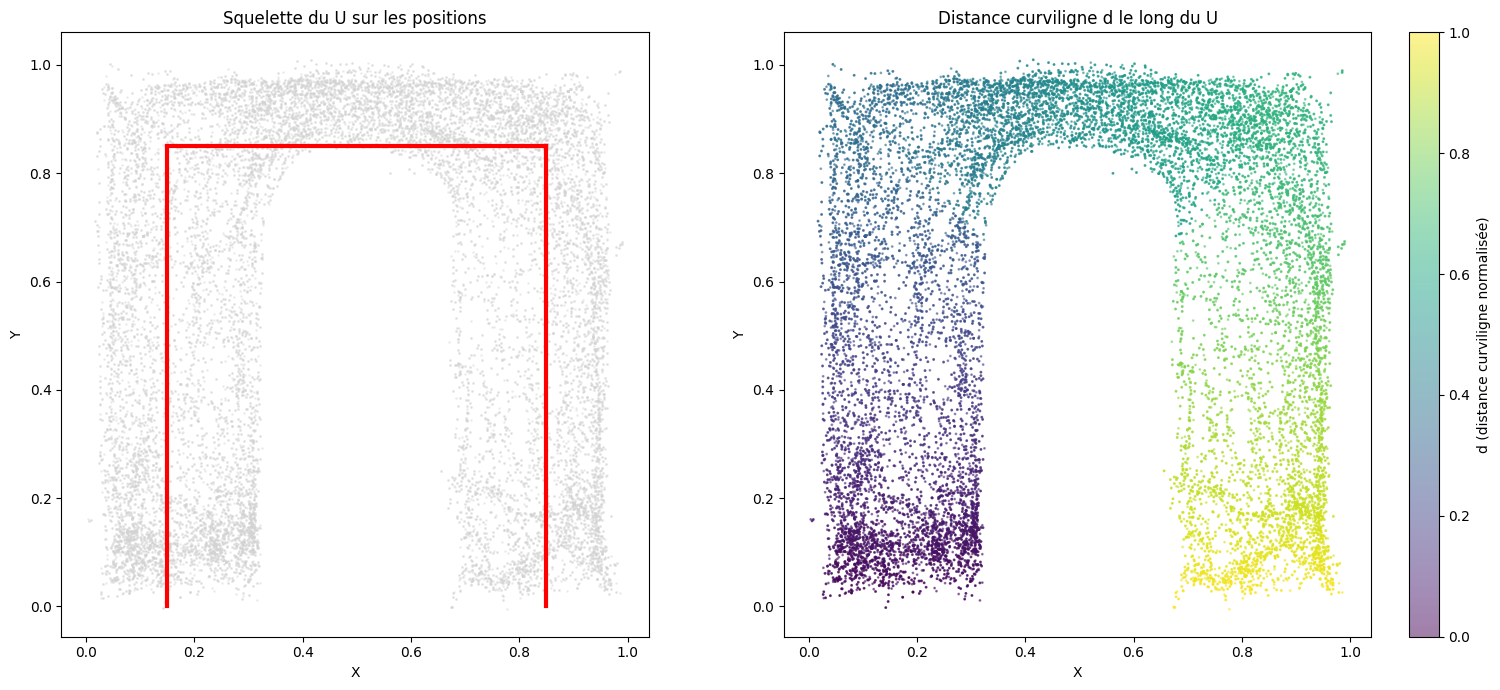

In [50]:
# --- Visualisation du squelette et de d ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Squelette du U sur les positions
axes[0].scatter(positions[:, 0], positions[:, 1], c='lightgray', s=1, alpha=0.3)
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0].plot([x1, x2], [y1, y2], 'r-', linewidth=3, label='Squelette')
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
axes[0].set_title('Squelette du U sur les positions')
axes[0].set_aspect('equal')

# 2. Positions colorées par d
sc = axes[1].scatter(positions[:, 0], positions[:, 1], c=curvilinear_d, s=1, alpha=0.5, cmap='viridis')
plt.colorbar(sc, ax=axes[1], label='d (distance curviligne normalisée)')
axes[1].set_xlabel('X'); axes[1].set_ylabel('Y')
axes[1].set_title('Distance curviligne d le long du U')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

## 4. Preprocessing : reconstruction de la séquence chronologique

In [51]:
def reconstruct_sequence(row, nGroups, nChannelsPerGroup, max_seq_len=128):
    """
    Reconstruit la séquence chronologique de spikes.
    """
    groups = row['groups']
    length = min(len(groups), max_seq_len)
    
    waveforms = {}
    for g in range(nGroups):
        nCh = nChannelsPerGroup[g]
        raw = row[f'group{g}']
        waveforms[g] = raw.reshape(-1, nCh, 32)
    
    seq_waveforms = []
    seq_shank_ids = []
    
    for t in range(length):
        g = int(groups[t])
        idx = int(row[f'indices{g}'][t])
        if idx > 0 and idx <= waveforms[g].shape[0]:
            seq_waveforms.append((waveforms[g][idx - 1], g))
            seq_shank_ids.append(g)
    
    return seq_waveforms, seq_shank_ids

# Test rapide
wf, sids = reconstruct_sequence(df_moving.iloc[0], nGroups, nChannelsPerGroup)
print(f'Premier exemple : {len(wf)} spikes réels dans la séquence')
print(f'Shanks utilisés : {set(sids)}')
print(f'Premier spike : shank={wf[0][1]}, shape={wf[0][0].shape}')

Premier exemple : 78 spikes réels dans la séquence
Shanks utilisés : {0, 1, 2, 3}
Premier spike : shank=1, shape=(4, 32)


## 5. Dataset PyTorch

In [52]:
MAX_SEQ_LEN = 128
MAX_CHANNELS = max(nChannelsPerGroup)  # 6

class SpikeSequenceDataset(Dataset):
    def __init__(self, dataframe, nGroups, nChannelsPerGroup, curvilinear_d, max_seq_len=MAX_SEQ_LEN):
        self.df = dataframe
        self.nGroups = nGroups
        self.nChannelsPerGroup = nChannelsPerGroup
        self.max_seq_len = max_seq_len
        
        # Pré-extraire les targets
        self.targets = np.array([[x[0], x[1]] for x in dataframe['pos']], dtype=np.float32)
        self.curvilinear_d = curvilinear_d.astype(np.float32)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq, shank_ids = reconstruct_sequence(row, self.nGroups, self.nChannelsPerGroup, self.max_seq_len)
        
        seq_len = len(seq)
        if seq_len == 0:
            seq_len = 1
            waveforms = np.zeros((1, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array([0], dtype=np.int64)
        else:
            waveforms = np.zeros((seq_len, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array(shank_ids, dtype=np.int64)
            for t, (wf, g) in enumerate(seq):
                nCh = wf.shape[0]
                waveforms[t, :nCh, :] = wf
        
        target = self.targets[idx]
        d = self.curvilinear_d[idx]
        return {
            'waveforms': torch.from_numpy(waveforms),
            'shank_ids': torch.from_numpy(shank_ids_arr),
            'seq_len': seq_len,
            'target': torch.from_numpy(target),
            'd': torch.tensor(d, dtype=torch.float32)
        }


def collate_fn(batch):
    """Collate avec padding dynamique."""
    max_len = max(item['seq_len'] for item in batch)
    batch_size = len(batch)
    
    waveforms = torch.zeros(batch_size, max_len, MAX_CHANNELS, 32)
    shank_ids = torch.zeros(batch_size, max_len, dtype=torch.long)
    mask = torch.ones(batch_size, max_len, dtype=torch.bool)
    targets = torch.stack([item['target'] for item in batch])
    d_targets = torch.stack([item['d'] for item in batch])
    
    for i, item in enumerate(batch):
        sl = item['seq_len']
        waveforms[i, :sl] = item['waveforms']
        shank_ids[i, :sl] = item['shank_ids']
        mask[i, :sl] = False
    
    return {
        'waveforms': waveforms,
        'shank_ids': shank_ids,
        'mask': mask,
        'targets': targets,
        'd_targets': d_targets
    }

print('Dataset et collate_fn définis (avec d curviligne).')

Dataset et collate_fn définis (avec d curviligne).


## 6. Loss de faisabilité (pénalisation hors labyrinthe)

La distance d'un point au squelette du U est calculée de manière **différentiable** :
pour chaque segment, on projette le point et on calcule la distance euclidienne.
On prend le minimum (via softmin pour la différentiabilité).

La pénalité est `ReLU(distance - corridor_half_width)²` : nulle si le point est dans le couloir, quadratique sinon.

In [53]:
class FeasibilityLoss(nn.Module):
    """Pénalise les prédictions (x, y) qui tombent hors du couloir du U.
    
    Calcule la distance au squelette du U de manière différentiable,
    puis applique une pénalité quadratique si la distance dépasse
    la demi-largeur du couloir.
    """
    
    def __init__(self, skeleton_segments, corridor_half_width):
        super().__init__()
        # Stocker les segments comme buffer (pas de gradient)
        self.register_buffer('segments', torch.tensor(skeleton_segments, dtype=torch.float32))
        self.corridor_half_width = corridor_half_width
    
    def forward(self, xy_pred):
        """
        Args:
            xy_pred: (batch, 2) - positions prédites
        Returns:
            loss: scalar - pénalité moyenne
        """
        px = xy_pred[:, 0]  # (batch,)
        py = xy_pred[:, 1]  # (batch,)
        
        distances = []
        for i in range(self.segments.shape[0]):
            x1, y1, x2, y2 = self.segments[i]
            dx, dy = x2 - x1, y2 - y1
            seg_len_sq = dx**2 + dy**2
            
            # Projection paramétrique t ∈ [0, 1]
            t = ((px - x1) * dx + (py - y1) * dy) / (seg_len_sq + 1e-8)
            t = t.clamp(0.0, 1.0)
            
            # Point projeté
            proj_x = x1 + t * dx
            proj_y = y1 + t * dy
            
            # Distance au segment
            dist = torch.sqrt((px - proj_x)**2 + (py - proj_y)**2 + 1e-8)
            distances.append(dist)
        
        # Distance minimale au squelette
        distances = torch.stack(distances, dim=1)  # (batch, n_segments)
        min_dist = distances.min(dim=1).values      # (batch,)
        
        # Pénalité : quadratique au-delà de la demi-largeur du couloir
        penalty = torch.relu(min_dist - self.corridor_half_width) ** 2
        
        return penalty.mean()


# Test
feas_loss = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH)

# Points dans le couloir → pénalité ~0
in_corridor = torch.tensor([[0.15, 0.5], [0.85, 0.3], [0.5, 0.85]], dtype=torch.float32)
# Points hors couloir → pénalité > 0
outside = torch.tensor([[0.5, 0.3], [0.5, 0.5], [0.5, 0.0]], dtype=torch.float32)

print(f'Pénalité (dans le couloir) : {feas_loss(in_corridor).item():.6f}')
print(f'Pénalité (hors couloir)    : {feas_loss(outside).item():.6f}')

Pénalité (dans le couloir) : 0.000000
Pénalité (hors couloir)    : 0.040000


## 7. Architecture du modèle

Identique au notebook 02, avec :
- **Spike dropout + Gaussian noise** (comme 02d)
- **Tête curviligne** (`d_head`) : prédit d ∈ [0, 1] via sigmoid
- La loss de faisabilité est externe au modèle (calculée dans la boucle d'entraînement)

In [54]:
class SpikeEncoder(nn.Module):
    """Encode un waveform (MAX_CH, 32) en un vecteur de dimension embed_dim."""
    
    def __init__(self, n_channels, embed_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, embed_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
    
    def forward(self, x):
        return self.conv(x).squeeze(-1)


class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""
    
    def __init__(self, embed_dim, max_len=256):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class SpikeTransformer(nn.Module):
    def __init__(self, nGroups, nChannelsPerGroup, embed_dim=64, nhead=4, 
                 num_layers=2, dropout=0.2, spike_dropout=0.15, noise_std=0.5,
                 max_channels=MAX_CHANNELS):
        super().__init__()
        self.nGroups = nGroups
        self.embed_dim = embed_dim
        self.max_channels = max_channels
        self.spike_dropout = spike_dropout
        self.noise_std = noise_std
        
        # Un encodeur par shank
        self.spike_encoders = nn.ModuleList([
            SpikeEncoder(max_channels, embed_dim) for _ in range(nGroups)
        ])
        
        # Embedding de shank
        self.shank_embedding = nn.Embedding(nGroups, embed_dim)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(embed_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=nhead, dim_feedforward=embed_dim * 4,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers, enable_nested_tensor=False
        )
        
        # Tête position : mu (2) et log_sigma (2)
        self.mu_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 2)
        )
        self.log_sigma_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 2)
        )
        
        # Tête distance curviligne : d ∈ [0, 1]
        self.d_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 1),
            nn.Sigmoid()  # borne la sortie à [0, 1]
        )
    
    def _apply_spike_dropout(self, mask):
        if not self.training or self.spike_dropout <= 0:
            return mask
        drop_mask = torch.rand_like(mask.float()) < self.spike_dropout
        active = ~mask
        new_drops = drop_mask & active
        remaining = active & ~new_drops
        n_remaining = remaining.sum(dim=1)
        all_dropped = n_remaining == 0
        if all_dropped.any():
            new_drops[all_dropped] = False
        return mask | new_drops
    
    def _apply_waveform_noise(self, waveforms):
        if not self.training or self.noise_std <= 0:
            return waveforms
        noise = torch.randn_like(waveforms) * self.noise_std
        return waveforms + noise
    
    def forward(self, waveforms, shank_ids, mask):
        """
        Returns:
            mu: (batch, 2) - position prédite
            sigma: (batch, 2) - incertitude
            d_pred: (batch, 1) - distance curviligne prédite
        """
        batch_size, seq_len = waveforms.shape[:2]
        
        # Data augmentation
        mask = self._apply_spike_dropout(mask)
        waveforms = self._apply_waveform_noise(waveforms)
        
        # Encode chaque spike
        embeddings = torch.zeros(batch_size, seq_len, self.embed_dim, device=waveforms.device)
        for g in range(self.nGroups):
            group_mask = (shank_ids == g) & (~mask)
            if group_mask.any():
                group_wf = waveforms[group_mask]
                group_emb = self.spike_encoders[g](group_wf)
                embeddings[group_mask] = group_emb
        
        # Shank embedding + Positional encoding
        shank_emb = self.shank_embedding(shank_ids)
        embeddings = embeddings + shank_emb
        embeddings = self.pos_encoding(embeddings)
        
        # Transformer
        encoded = self.transformer(embeddings, src_key_padding_mask=mask)
        
        # Masked average pooling
        active_mask = (~mask).unsqueeze(-1).float()
        pooled = (encoded * active_mask).sum(dim=1) / (active_mask.sum(dim=1) + 1e-8)
        
        # Sorties
        mu = self.mu_head(pooled)
        log_sigma = self.log_sigma_head(pooled)
        sigma = torch.exp(log_sigma)
        d_pred = self.d_head(pooled)
        
        return mu, sigma, d_pred


# Test rapide
SPIKE_DROPOUT = 0.15
NOISE_STD = 0.5
model = SpikeTransformer(nGroups, nChannelsPerGroup, embed_dim=64, nhead=4, num_layers=2,
                         spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD)
n_params = sum(p.numel() for p in model.parameters())
print(f'Modèle créé : {n_params:,} paramètres')
print(f'Têtes de sortie : position (mu + sigma) + distance curviligne (d)')
print(model)

Modèle créé : 141,829 paramètres
Têtes de sortie : position (mu + sigma) + distance curviligne (d)
SpikeTransformer(
  (spike_encoders): ModuleList(
    (0-3): 4 x SpikeEncoder(
      (conv): Sequential(
        (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): AdaptiveAvgPool1d(output_size=1)
      )
    )
  )
  (shank_embedding): Embedding(4, 64)
  (pos_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNor

## 8. Split et DataLoaders

In [55]:
from sklearn.model_selection import KFold

# Split temporel 90/10
split_idx = int(len(df_moving) * 0.9)
df_train_full = df_moving.iloc[:split_idx].reset_index(drop=True)
df_test = df_moving.iloc[split_idx:].reset_index(drop=True)
d_train_full = curvilinear_d[:split_idx]
d_test = curvilinear_d[split_idx:]

print(f'Train (full) : {len(df_train_full)} exemples')
print(f'Test         : {len(df_test)} exemples')

# KFold
N_FOLDS = 2
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=41)

BATCH_SIZE = 64

# Test loader
test_dataset = SpikeSequenceDataset(df_test, nGroups, nChannelsPerGroup, d_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=collate_fn, num_workers=0)

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_full)):
    print(f'  Fold {fold+1}: train={len(train_idx)}, val={len(val_idx)}')

print(f'\nTest: {len(test_dataset)} exemples, {len(test_loader)} batches')

Train (full) : 20676 exemples
Test         : 2298 exemples
  Fold 1: train=10338, val=10338
  Fold 2: train=10338, val=10338

Test: 2298 exemples, 36 batches


## 9. Entraînement (5-Fold Cross-Validation)

**Loss combinée** :
```
L = L_position (Gaussian NLL sur x, y)
  + λ_d * L_curvilinear (MSE sur d)
  + λ_feas * L_feasibility (pénalité hors labyrinthe)
```

In [56]:
# Hyperparamètres
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 2
DROPOUT = 0.2
SPIKE_DROPOUT = 0.15
NOISE_STD = 0.5
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 10
PATIENCE = 7

# Poids des loss auxiliaires
LAMBDA_D = 1.0       # poids de la loss curviligne
LAMBDA_FEAS = 10.0   # poids de la pénalité hors labyrinthe

print(f'Hyperparamètres : embed_dim={EMBED_DIM}, nhead={NHEAD}, layers={NUM_LAYERS}, dropout={DROPOUT}')
print(f'Data augmentation : spike dropout={SPIKE_DROPOUT:.0%}, gaussian noise std={NOISE_STD}')
print(f'Loss : GaussianNLL + {LAMBDA_D}*MSE(d) + {LAMBDA_FEAS}*Feasibility')
print(f'Entraînement : {EPOCHS} epochs max, patience={PATIENCE}, LR={LR}')
print(f'Device : {DEVICE}')

Hyperparamètres : embed_dim=64, nhead=4, layers=2, dropout=0.2
Data augmentation : spike dropout=15%, gaussian noise std=0.5
Loss : GaussianNLL + 1.0*MSE(d) + 10.0*Feasibility
Entraînement : 10 epochs max, patience=7, LR=0.001
Device : cuda


In [57]:
def train_epoch(model, loader, optimizer, scheduler, criterion_nll, criterion_d, feas_loss, device):
    model.train()
    total_loss = 0
    total_pos_loss = 0
    total_d_loss = 0
    total_feas_loss = 0
    n_batches = 0
    
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        d_targets = batch['d_targets'].to(device)
        
        optimizer.zero_grad()
        mu, sigma, d_pred = model(wf, sid, mask)
        
        # Loss position (Gaussian NLL)
        loss_pos = criterion_nll(mu, targets, sigma ** 2)
        
        # Loss curviligne (MSE)
        loss_d = criterion_d(d_pred.squeeze(-1), d_targets)
        
        # Loss faisabilité
        loss_feas = feas_loss(mu)
        
        # Loss totale
        loss = loss_pos + LAMBDA_D * loss_d + LAMBDA_FEAS * loss_feas
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        total_pos_loss += loss_pos.item()
        total_d_loss += loss_d.item()
        total_feas_loss += loss_feas.item()
        n_batches += 1
    
    return (total_loss / n_batches, total_pos_loss / n_batches, 
            total_d_loss / n_batches, total_feas_loss / n_batches)


@torch.no_grad()
def eval_epoch(model, loader, criterion_nll, criterion_d, feas_loss, device):
    model.eval()
    total_loss = 0
    total_pos_loss = 0
    total_d_loss = 0
    total_feas_loss = 0
    n_batches = 0
    all_mu = []
    all_sigma = []
    all_d_pred = []
    all_targets = []
    all_d_targets = []
    
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        d_targets = batch['d_targets'].to(device)
        
        mu, sigma, d_pred = model(wf, sid, mask)
        
        loss_pos = criterion_nll(mu, targets, sigma ** 2)
        loss_d = criterion_d(d_pred.squeeze(-1), d_targets)
        loss_feas = feas_loss(mu)
        loss = loss_pos + LAMBDA_D * loss_d + LAMBDA_FEAS * loss_feas
        
        total_loss += loss.item()
        total_pos_loss += loss_pos.item()
        total_d_loss += loss_d.item()
        total_feas_loss += loss_feas.item()
        n_batches += 1
        all_mu.append(mu.cpu().numpy())
        all_sigma.append(sigma.cpu().numpy())
        all_d_pred.append(d_pred.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
        all_d_targets.append(d_targets.cpu().numpy())
    
    return (total_loss / n_batches, total_pos_loss / n_batches,
            total_d_loss / n_batches, total_feas_loss / n_batches,
            np.concatenate(all_mu), np.concatenate(all_sigma),
            np.concatenate(all_d_pred), np.concatenate(all_targets),
            np.concatenate(all_d_targets))

In [58]:
# Boucle d'entraînement avec KFold
fold_results = []
all_train_losses = {}
all_val_losses = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_full)):
    print(f'\n{"="*60}')
    print(f'FOLD {fold+1}/{N_FOLDS}')
    print(f'{"="*60}')
    
    # Datasets pour ce fold
    df_fold_train = df_train_full.iloc[train_idx].reset_index(drop=True)
    df_fold_val = df_train_full.iloc[val_idx].reset_index(drop=True)
    d_fold_train = d_train_full[train_idx]
    d_fold_val = d_train_full[val_idx]
    
    fold_train_dataset = SpikeSequenceDataset(df_fold_train, nGroups, nChannelsPerGroup, d_fold_train)
    fold_val_dataset = SpikeSequenceDataset(df_fold_val, nGroups, nChannelsPerGroup, d_fold_val)
    
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                   collate_fn=collate_fn, num_workers=0)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                 collate_fn=collate_fn, num_workers=0)
    
    print(f'  Train: {len(fold_train_dataset)}, Val: {len(fold_val_dataset)}')
    
    # Nouveau modèle
    model = SpikeTransformer(
        nGroups, nChannelsPerGroup,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(fold_train_loader)
    )
    criterion_nll = nn.GaussianNLLLoss()
    criterion_d = nn.MSELoss()
    feas_loss_fn = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH).to(DEVICE)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    model_path = f'../outputs/best_transformer_02f_fold{fold+1}.pt'
    
    for epoch in range(EPOCHS):
        t_loss, t_pos, t_d, t_feas = train_epoch(
            model, fold_train_loader, optimizer, scheduler,
            criterion_nll, criterion_d, feas_loss_fn, DEVICE
        )
        v_loss, v_pos, v_d, v_feas, _, _, _, _, _ = eval_epoch(
            model, fold_val_loader, criterion_nll, criterion_d, feas_loss_fn, DEVICE
        )
        
        train_losses.append(t_loss)
        val_losses.append(v_loss)
        
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            print(f'  Epoch {epoch+1:02d}/{EPOCHS} | Train: {t_loss:.5f} (pos={t_pos:.5f}, d={t_d:.5f}, feas={t_feas:.6f}) | Val: {v_loss:.5f}')
        
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f'  Early stopping a epoch {epoch+1}')
                break
    
    all_train_losses[fold] = train_losses
    all_val_losses[fold] = val_losses
    
    # Évaluer sur la validation de ce fold
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    _, _, _, _, val_mu, val_sigma, val_d_pred, val_targets, val_d_targets = eval_epoch(
        model, fold_val_loader, criterion_nll, criterion_d, feas_loss_fn, DEVICE
    )
    val_eucl = np.sqrt((val_targets[:, 0] - val_mu[:, 0])**2 + (val_targets[:, 1] - val_mu[:, 1])**2)
    val_d_mae = np.abs(val_d_targets - val_d_pred.squeeze()).mean()
    
    # % de prédictions hors labyrinthe
    val_dist_to_skel = np.array([
        compute_distance_to_skeleton(val_mu[i, 0], val_mu[i, 1]) for i in range(len(val_mu))
    ])
    pct_outside = (val_dist_to_skel > CORRIDOR_HALF_WIDTH).mean()
    
    fold_results.append({
        'fold': fold + 1,
        'best_val_loss': best_val_loss,
        'val_eucl_mean': val_eucl.mean(),
        'val_r2_x': r2_score(val_targets[:, 0], val_mu[:, 0]),
        'val_r2_y': r2_score(val_targets[:, 1], val_mu[:, 1]),
        'val_d_mae': val_d_mae,
        'val_pct_outside': pct_outside,
        'epochs': len(train_losses),
    })
    print(f'  Best val loss: {best_val_loss:.5f} | Eucl: {val_eucl.mean():.4f} | R2: X={fold_results[-1]["val_r2_x"]:.4f}, Y={fold_results[-1]["val_r2_y"]:.4f}')
    print(f'  d MAE: {val_d_mae:.4f} | Hors labyrinthe: {pct_outside:.1%}')

# Résumé
print(f'\n{"="*60}')
print(f'RESUME CROSS-VALIDATION ({N_FOLDS} folds)')
print(f'{"="*60}')
for r in fold_results:
    print(f'  Fold {r["fold"]}: NLL={r["best_val_loss"]:.5f} | Eucl={r["val_eucl_mean"]:.4f} | R2_X={r["val_r2_x"]:.4f} | R2_Y={r["val_r2_y"]:.4f} | d_MAE={r["val_d_mae"]:.4f} | hors={r["val_pct_outside"]:.1%}')

mean_eucl = np.mean([r['val_eucl_mean'] for r in fold_results])
std_eucl = np.std([r['val_eucl_mean'] for r in fold_results])
mean_r2_x = np.mean([r['val_r2_x'] for r in fold_results])
mean_r2_y = np.mean([r['val_r2_y'] for r in fold_results])
mean_d_mae = np.mean([r['val_d_mae'] for r in fold_results])
mean_outside = np.mean([r['val_pct_outside'] for r in fold_results])
print(f'\n  Moyenne : Eucl={mean_eucl:.4f} (+/- {std_eucl:.4f}) | R2_X={mean_r2_x:.4f} | R2_Y={mean_r2_y:.4f} | d_MAE={mean_d_mae:.4f} | hors={mean_outside:.1%}')


FOLD 1/2
  Train: 10338, Val: 10338
  Epoch 01/10 | Train: -0.28149 (pos=-0.40455, d=0.08852, feas=0.003454) | Val: -0.48120
  Epoch 06/10 | Train: -0.70603 (pos=-0.79689, d=0.07680, feas=0.001406) | Val: -0.76094
  Epoch 10/10 | Train: -0.83248 (pos=-0.91084, d=0.06730, feas=0.001106) | Val: -0.87371
  Best val loss: -0.87371 | Eucl: 0.3293 | R2: X=0.0421, Y=0.5568
  d MAE: 0.2036 | Hors labyrinthe: 44.5%

FOLD 2/2
  Train: 10338, Val: 10338
  Epoch 01/10 | Train: -0.27516 (pos=-0.39524, d=0.09015, feas=0.002992) | Val: -0.50007
  Epoch 06/10 | Train: -0.70185 (pos=-0.79246, d=0.07518, feas=0.001542) | Val: -0.80599
  Epoch 10/10 | Train: -0.84626 (pos=-0.93612, d=0.06558, feas=0.002429) | Val: -0.88781
  Best val loss: -0.88781 | Eucl: 0.3048 | R2: X=0.2170, Y=0.5502
  d MAE: 0.1919 | Hors labyrinthe: 33.8%

RESUME CROSS-VALIDATION (2 folds)
  Fold 1: NLL=-0.87371 | Eucl=0.3293 | R2_X=0.0421 | R2_Y=0.5568 | d_MAE=0.2036 | hors=44.5%
  Fold 2: NLL=-0.88781 | Eucl=0.3048 | R2_X=0.2170

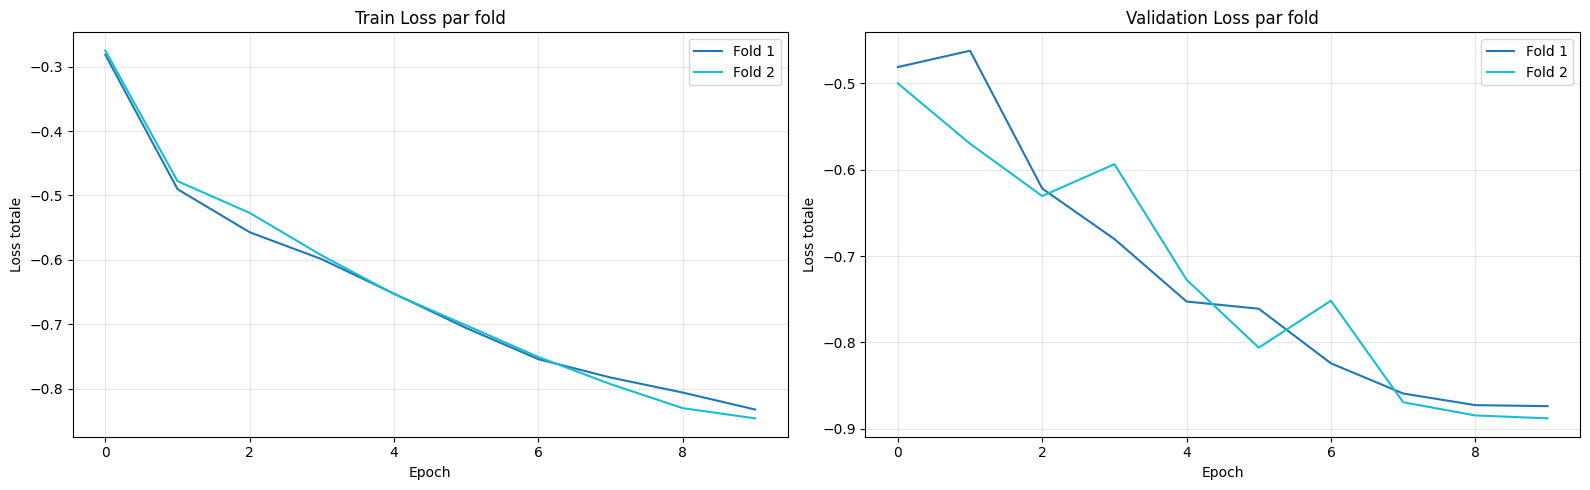

In [59]:
# Courbes d'entraînement par fold
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

colors = plt.cm.tab10(np.linspace(0, 1, N_FOLDS))

for fold in range(N_FOLDS):
    axes[0].plot(all_train_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')
    axes[1].plot(all_val_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')

axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss totale')
axes[0].set_title('Train Loss par fold'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss totale')
axes[1].set_title('Validation Loss par fold'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Évaluation finale sur le test set

In [60]:
# Évaluation ensemble des 5 folds sur le test set
criterion_nll = nn.GaussianNLLLoss()
criterion_d = nn.MSELoss()
feas_loss_fn = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH).to(DEVICE)

all_fold_mu = []
all_fold_sigma = []
all_fold_d = []

for fold in range(N_FOLDS):
    model_path = f'../outputs/best_transformer_02f_fold{fold+1}.pt'
    model = SpikeTransformer(
        nGroups, nChannelsPerGroup,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    
    _, _, _, _, fold_mu, fold_sigma, fold_d, y_test, d_test_targets = eval_epoch(
        model, test_loader, criterion_nll, criterion_d, feas_loss_fn, DEVICE
    )
    all_fold_mu.append(fold_mu)
    all_fold_sigma.append(fold_sigma)
    all_fold_d.append(fold_d)
    
    fold_eucl = np.sqrt((y_test[:, 0] - fold_mu[:, 0])**2 + (y_test[:, 1] - fold_mu[:, 1])**2)
    print(f'Fold {fold+1} sur test: Eucl={fold_eucl.mean():.4f}')

# Ensemble
all_fold_mu = np.stack(all_fold_mu)
all_fold_sigma = np.stack(all_fold_sigma)
all_fold_d = np.stack(all_fold_d)

y_pred = all_fold_mu.mean(axis=0)
d_pred_ensemble = all_fold_d.mean(axis=0).squeeze()

# Sigma ensemble (loi de la variance totale)
mean_var = (all_fold_sigma ** 2).mean(axis=0)
var_mu = all_fold_mu.var(axis=0)
y_sigma = np.sqrt(mean_var + var_mu)

# Métriques position
mse_x = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse_y = mean_squared_error(y_test[:, 1], y_pred[:, 1])
mae_x = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_y = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_x = r2_score(y_test[:, 0], y_pred[:, 0])
r2_y = r2_score(y_test[:, 1], y_pred[:, 1])
eucl_errors = np.sqrt((y_test[:, 0] - y_pred[:, 0])**2 + (y_test[:, 1] - y_pred[:, 1])**2)

# Métriques d
d_mae = np.abs(d_test_targets - d_pred_ensemble).mean()
d_r2 = r2_score(d_test_targets, d_pred_ensemble)

# % hors labyrinthe
test_dist_to_skel = np.array([
    compute_distance_to_skeleton(y_pred[i, 0], y_pred[i, 1]) for i in range(len(y_pred))
])
pct_outside = (test_dist_to_skel > CORRIDOR_HALF_WIDTH).mean()

print(f'\n=== Transformer 02f : (x,y,d) + Feasibility — Ensemble ({N_FOLDS} folds) ===')
print(f'  MSE  : X={mse_x:.5f}, Y={mse_y:.5f}')
print(f'  MAE  : X={mae_x:.4f}, Y={mae_y:.4f}')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')
print(f'\n  d curviligne : MAE={d_mae:.4f}, R²={d_r2:.4f}')
print(f'  Hors labyrinthe : {pct_outside:.1%}')
print(f'\n  Sigma moyen : X={y_sigma[:, 0].mean():.4f}, Y={y_sigma[:, 1].mean():.4f}')

Fold 1 sur test: Eucl=0.2964
Fold 2 sur test: Eucl=0.2785

=== Transformer 02f : (x,y,d) + Feasibility — Ensemble (2 folds) ===
  MSE  : X=0.06565, Y=0.04619
  MAE  : X=0.1963, Y=0.1606
  R²   : X=0.1817, Y=0.5630
  Eucl : mean=0.2827, median=0.2397, p90=0.5565

  d curviligne : MAE=0.1741, R²=0.2994
  Hors labyrinthe : 34.8%

  Sigma moyen : X=0.2664, Y=0.2085


## 11. Visualisations

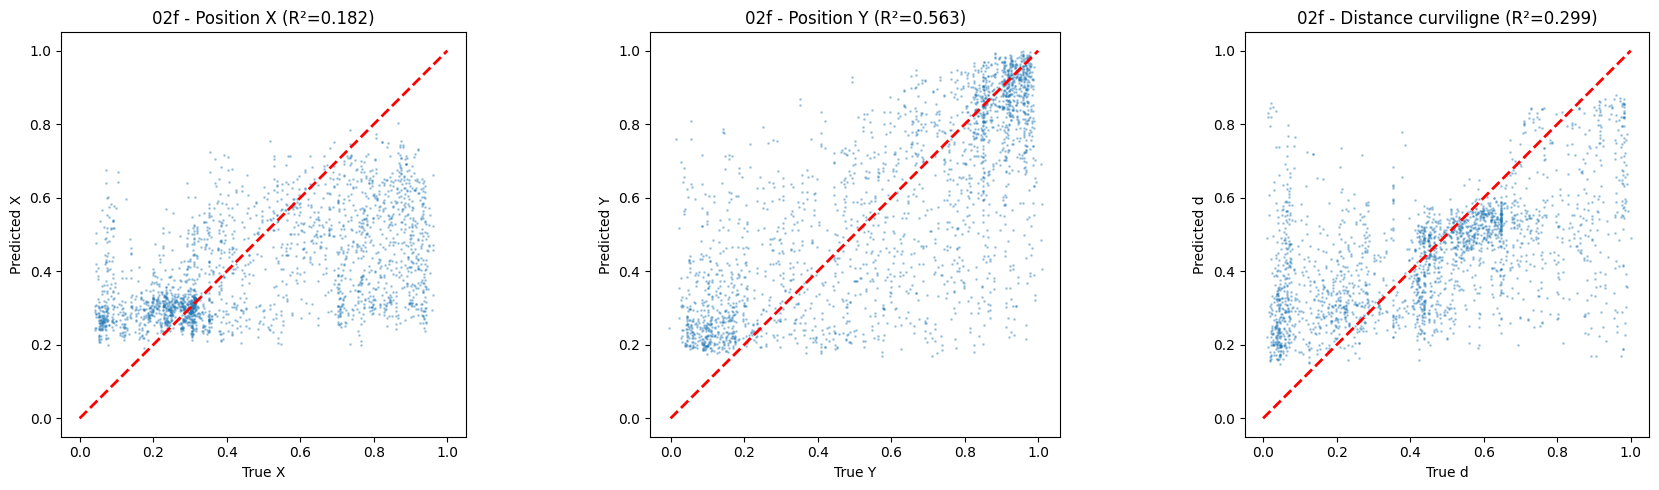

In [61]:
# --- Scatter pred vs true ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=1, alpha=0.3)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('True X'); axes[0].set_ylabel('Predicted X')
axes[0].set_title(f'02f - Position X (R²={r2_x:.3f})')
axes[0].set_aspect('equal')

axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=1, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('True Y'); axes[1].set_ylabel('Predicted Y')
axes[1].set_title(f'02f - Position Y (R²={r2_y:.3f})')
axes[1].set_aspect('equal')

axes[2].scatter(d_test_targets, d_pred_ensemble, s=1, alpha=0.3)
axes[2].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[2].set_xlabel('True d'); axes[2].set_ylabel('Predicted d')
axes[2].set_title(f'02f - Distance curviligne (R²={d_r2:.3f})')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

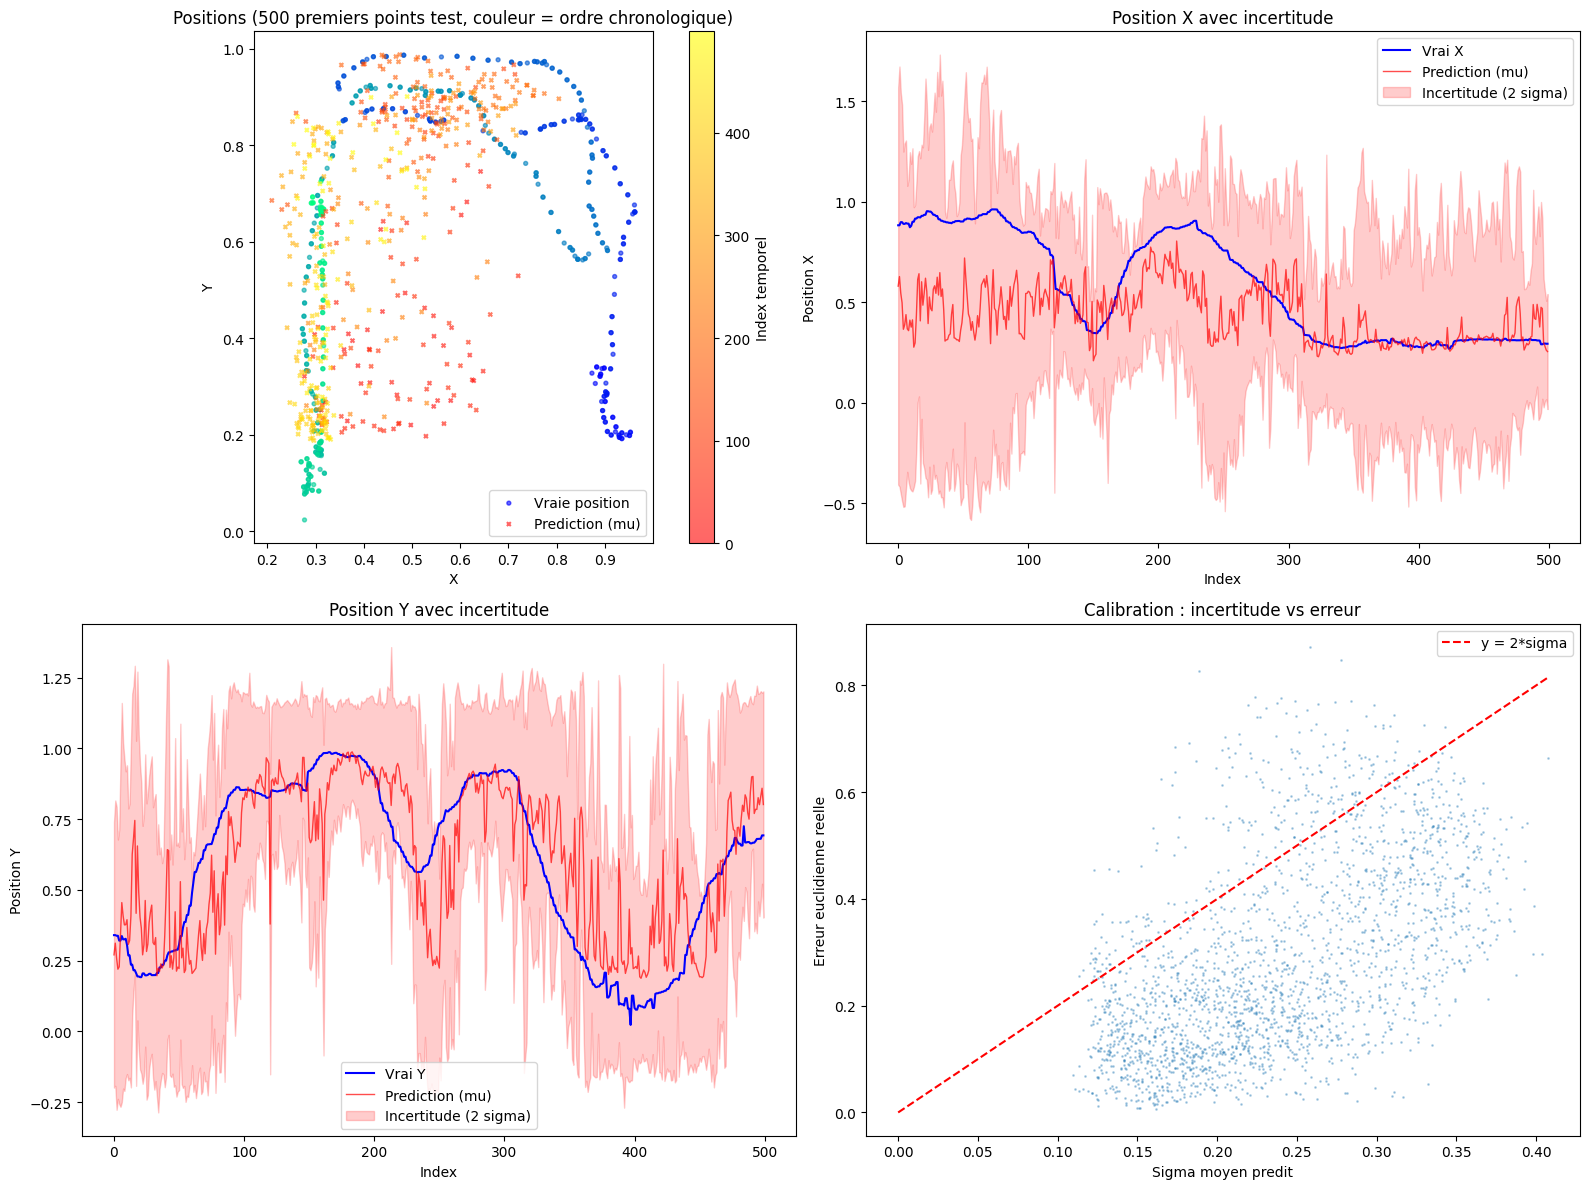

Calibration de l'incertitude :
  Erreur < 1*sigma : 46.3% (attendu ~39% pour gaussienne 2D)
  Erreur < 2*sigma : 88.1% (attendu ~86%)
  Erreur < 3*sigma : 98.3% (attendu ~99%)


In [62]:
# --- Points prédits vs vrais avec incertitude ---
segment = slice(0, 500)
seg_idx = np.arange(500)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Points 2D colores par ordre chronologique
colors = np.arange(500)
axes[0, 0].scatter(y_test[segment, 0], y_test[segment, 1], c=colors, cmap='winter', s=8, alpha=0.6, label='Vraie position')
sc = axes[0, 0].scatter(y_pred[segment, 0], y_pred[segment, 1], c=colors, cmap='autumn', s=8, alpha=0.6, marker='x', label='Prediction (mu)')
axes[0, 0].set_xlabel('X'); axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Positions (500 premiers points test, couleur = ordre chronologique)')
axes[0, 0].legend()
axes[0, 0].set_aspect('equal')
cbar = plt.colorbar(sc, ax=axes[0, 0])
cbar.set_label('Index temporel')

# 2. Position X avec bande d'incertitude (mu +/- 2*sigma)
axes[0, 1].plot(seg_idx, y_test[segment, 0], 'b-', label='Vrai X', linewidth=1.5)
axes[0, 1].plot(seg_idx, y_pred[segment, 0], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[0, 1].fill_between(seg_idx, 
                         y_pred[segment, 0] - 2 * y_sigma[segment, 0],
                         y_pred[segment, 0] + 2 * y_sigma[segment, 0],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[0, 1].set_xlabel('Index'); axes[0, 1].set_ylabel('Position X')
axes[0, 1].set_title('Position X avec incertitude')
axes[0, 1].legend()

# 3. Position Y avec bande d'incertitude
axes[1, 0].plot(seg_idx, y_test[segment, 1], 'b-', label='Vrai Y', linewidth=1.5)
axes[1, 0].plot(seg_idx, y_pred[segment, 1], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[1, 0].fill_between(seg_idx,
                         y_pred[segment, 1] - 2 * y_sigma[segment, 1],
                         y_pred[segment, 1] + 2 * y_sigma[segment, 1],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[1, 0].set_xlabel('Index'); axes[1, 0].set_ylabel('Position Y')
axes[1, 0].set_title('Position Y avec incertitude')
axes[1, 0].legend()

# 4. Erreur euclidienne vs sigma moyen
sigma_mean = (y_sigma[:, 0] + y_sigma[:, 1]) / 2
axes[1, 1].scatter(sigma_mean, eucl_errors, s=1, alpha=0.3)
axes[1, 1].set_xlabel('Sigma moyen predit'); axes[1, 1].set_ylabel('Erreur euclidienne reelle')
axes[1, 1].set_title('Calibration : incertitude vs erreur')
# Ligne de reference y=2*x (si bien calibre, ~95% des points sous cette ligne)
sigma_range = np.linspace(0, sigma_mean.max(), 100)
axes[1, 1].plot(sigma_range, 2 * sigma_range, 'r--', label='y = 2*sigma', linewidth=1.5)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calibration : quel % des vraies positions tombe dans l'intervalle predit ?
in_1sigma = np.mean(eucl_errors < sigma_mean)
in_2sigma = np.mean(eucl_errors < 2 * sigma_mean)
in_3sigma = np.mean(eucl_errors < 3 * sigma_mean)
print(f'Calibration de l\'incertitude :')
print(f'  Erreur < 1*sigma : {in_1sigma:.1%} (attendu ~39% pour gaussienne 2D)')
print(f'  Erreur < 2*sigma : {in_2sigma:.1%} (attendu ~86%)')
print(f'  Erreur < 3*sigma : {in_3sigma:.1%} (attendu ~99%)')

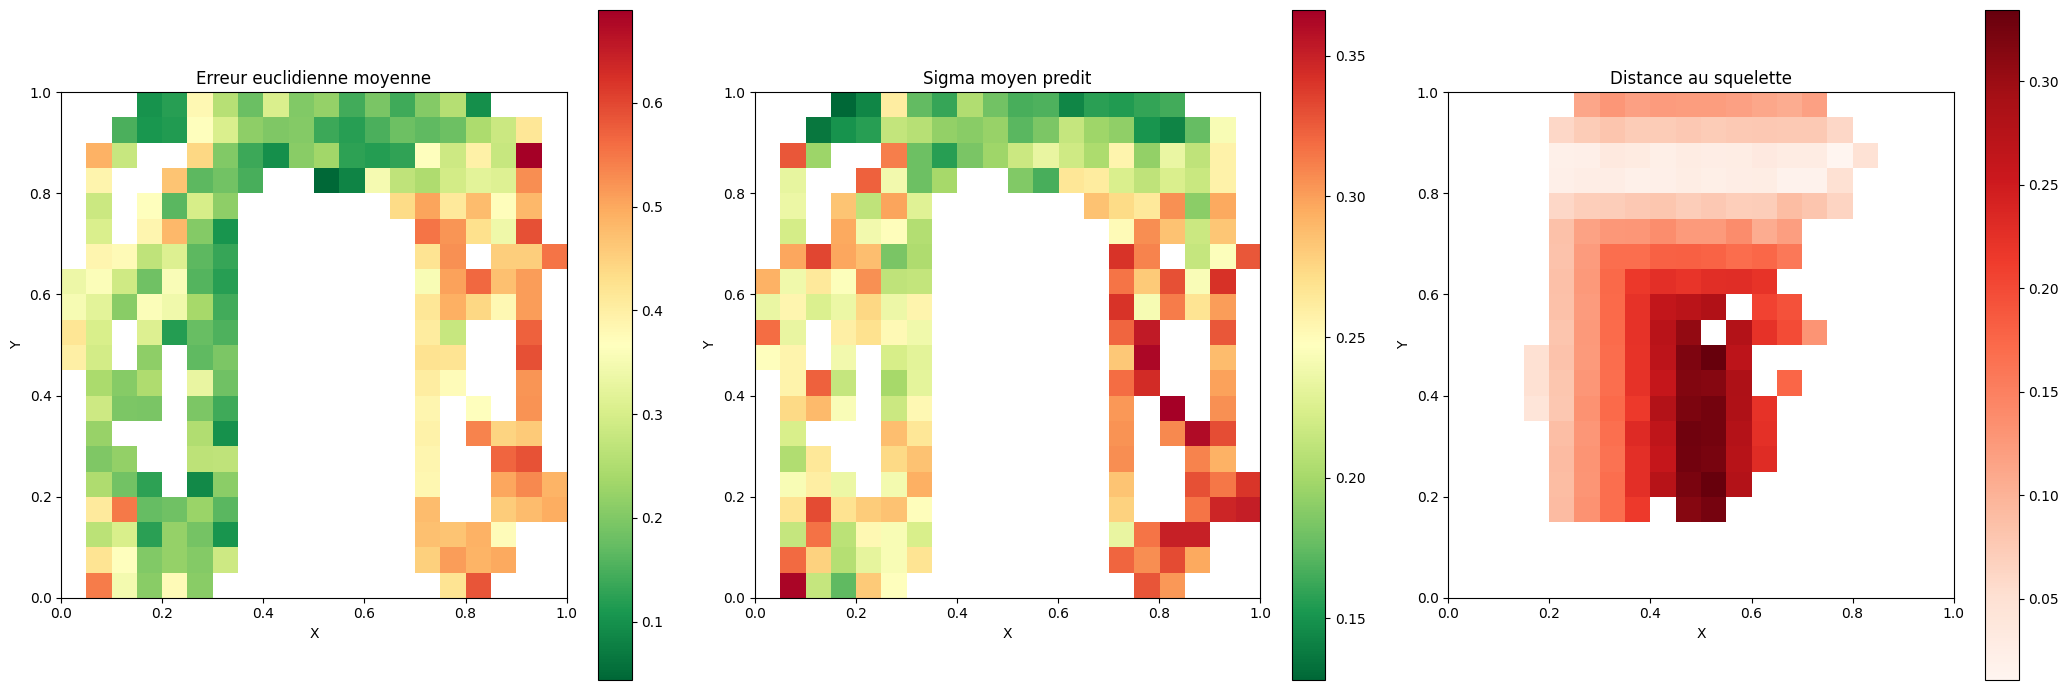

In [63]:
# --- Heatmaps : erreur + hors labyrinthe ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

nbins = 20
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for ax_idx, (title, values, cmap) in enumerate([
    ('Erreur euclidienne moyenne', eucl_errors, 'RdYlGn_r'),
    ('Sigma moyen predit', (y_sigma[:, 0] + y_sigma[:, 1]) / 2, 'RdYlGn_r'),
    ('Distance au squelette', test_dist_to_skel, 'Reds')
]):
    val_map = np.full((nbins, nbins), np.nan)
    count_map = np.zeros((nbins, nbins))
    
    # Pour la heatmap de distance, utiliser les prédictions ; pour les autres, les vraies positions
    pos_for_binning = y_pred if ax_idx == 2 else y_test
    
    for i in range(len(pos_for_binning)):
        xi = np.clip(np.searchsorted(x_edges, pos_for_binning[i, 0]) - 1, 0, nbins - 1)
        yi = np.clip(np.searchsorted(y_edges, pos_for_binning[i, 1]) - 1, 0, nbins - 1)
        if np.isnan(val_map[yi, xi]):
            val_map[yi, xi] = 0
        val_map[yi, xi] += values[i]
        count_map[yi, xi] += 1
    
    mean_map = np.where(count_map > 0, val_map / count_map, np.nan)
    
    im = axes[ax_idx].imshow(mean_map, origin='lower', aspect='equal', 
                              cmap=cmap, extent=[0, 1, 0, 1])
    axes[ax_idx].set_xlabel('X'); axes[ax_idx].set_ylabel('Y')
    axes[ax_idx].set_title(title)
    plt.colorbar(im, ax=axes[ax_idx])

plt.tight_layout()
plt.show()

## 12. Sauvegarde des prédictions

In [64]:
np.save('../outputs/preds_transformer_02f.npy', y_pred)
np.save('../outputs/sigma_transformer_02f.npy', y_sigma)
np.save('../outputs/d_pred_transformer_02f.npy', d_pred_ensemble)
np.save('../outputs/y_test_transformer_02f.npy', y_test)
np.save('../outputs/d_test_transformer_02f.npy', d_test_targets)
print(f'Predictions ensemble ({N_FOLDS} folds) sauvegardees.')
print(f'  preds_transformer_02f.npy : mu ensemble ({y_pred.shape})')
print(f'  sigma_transformer_02f.npy : sigma ensemble ({y_sigma.shape})')
print(f'  d_pred_transformer_02f.npy : d ensemble ({d_pred_ensemble.shape})')
print(f'  y_test_transformer_02f.npy : targets ({y_test.shape})')
print(f'  d_test_transformer_02f.npy : d targets ({d_test_targets.shape})')

Predictions ensemble (2 folds) sauvegardees.
  preds_transformer_02f.npy : mu ensemble ((2298, 2))
  sigma_transformer_02f.npy : sigma ensemble ((2298, 2))
  d_pred_transformer_02f.npy : d ensemble ((2298,))
  y_test_transformer_02f.npy : targets ((2298, 2))
  d_test_transformer_02f.npy : d targets ((2298,))


## 13. Interprétation

### Trois composants de la loss

1. **Gaussian NLL (position)** : loss principale, identique aux notebooks précédents. Prédit mu et sigma pour (x, y).

2. **MSE curviligne (d)** : tâche auxiliaire qui force le backbone à encoder la topologie du U. Les deux bras ont des valeurs de d très différentes (d~0 pour le bas du bras gauche, d~1 pour le bas du bras droit), ce qui aide le Transformer à les distinguer même si leurs (x, y) sont proches.

3. **Feasibility loss** : pénalise quadratiquement les prédictions (x, y) qui tombent hors du couloir du U. Calculée de manière différentiable via la projection sur le squelette.

### Métriques supplémentaires

- **d MAE** : erreur moyenne sur la distance curviligne (qualité de la tâche auxiliaire)
- **d R²** : coefficient de détermination sur d
- **% hors labyrinthe** : fraction des prédictions qui tombent en dehors du couloir

### Impact attendu

- **Réduction de l'ambiguïté gauche/droite** : la tête d force le backbone à distinguer les deux bras
- **Moins de prédictions hors couloir** : la feasibility loss pousse les prédictions vers le labyrinthe
- **Meilleure calibration** : le modèle devrait être plus confiant dans les zones non-ambiguës

### Hyperparamètres à tuner

- `LAMBDA_D = 1.0` : poids de la loss curviligne. Si trop élevé, le modèle optimise d au détriment de (x, y)
- `LAMBDA_FEAS = 10.0` : poids de la pénalité. Élevé pour décourager fortement les prédictions hors couloir
- Les deux peuvent être ajustés selon les résultats